## Quation 5 part a

In [100]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

raw_heart_data = np.loadtxt('heart.csv',delimiter=',', dtype=str)

# delete first row which are just column names
column_names = raw_heart_data[0].T
raw_heart_data = np.delete(raw_heart_data, 0, axis=0)

# change from type str to float
raw_heart_data = raw_heart_data.astype(float)

# randomize the data
np.random.shuffle(raw_heart_data)
print(raw_heart_data)
print(np.shape(raw_heart_data))

[[66.  1.  0. ...  1.  2.  0.]
 [61.  0.  0. ...  0.  3.  0.]
 [57.  1.  0. ...  1.  3.  0.]
 ...
 [42.  1.  2. ...  0.  2.  1.]
 [59.  1.  0. ...  2.  1.  0.]
 [58.  1.  0. ...  2.  3.  0.]]
(303, 14)


In [101]:
# separate data

heart_data = raw_heart_data[:,0:13]
heart_labels = raw_heart_data[:,13].T

training_data = heart_data[0:200]
test_data = heart_data[200:303]
training_labels = heart_labels[0:200]
test_labels = heart_labels[200:303]

print(np.shape(training_data))
print(np.shape(test_data))
print(np.shape(training_labels))
print(np.shape(test_labels))

(200, 13)
(103, 13)
(200,)
(103,)


In [102]:
# fit logistic regression

logistic_model = linear_model.LogisticRegression(max_iter=1000).fit(training_data, training_labels)
w = logistic_model.coef_
w

array([[-0.02005763, -0.86617396,  0.8690098 , -0.0100779 , -0.00220119,
        -0.23921064,  0.76978226,  0.00933036, -1.01111421, -0.56352958,
         0.64233241, -0.9426215 , -1.20314208]])

In [103]:
# sort indicies of highest magnitude to lowest
sorted_indicies = np.argsort(np.absolute(w[0]) * -1)

# three most influential feature
print("Three most influential features")
for i in sorted_indicies[0:3]:
    print("Index " + str(i) + " " + str(column_names[i]))

Three most influential features
Index 12 thal
Index 8 exang
Index 11 ca


## Question 5 part b

In [104]:
# get test error
test_accuracy = logistic_model.score(test_data, test_labels)
print("Test Error: " + str(1 - test_accuracy))

Test Error: 0.1747572815533981


## Question 5 part c

In [105]:
k = 5
total_error = 0
size = len(training_data) // k
for i in range(5):
    total_error += 1 - logistic_model.score(training_data[(i*size):(i*size+size)], training_labels[(i*size):(i*size+size)])
average_error = total_error / 5
print('5-fold cross-validation error: ' + str(average_error))

5-fold cross-validation error: 0.145


The test error and the cross-validation error are both about the same with an error of 0.145

In [106]:
s_feature_names = column_names[1:1+1]
s_feature_names = np.append(s_feature_names, column_names[3])
s_feature_names

array(['sex', 'trestbps'], dtype='<U8')

## Question 6 part a

In [107]:
k_models = {}

not_s = training_data
not_s_feature_names = column_names

test_data_copy = test_data

# find the first feature to be in S
min_error = 1
min_test_error = 1
min_feature = 0
for j in range(len(not_s[0])):
    k = 5
    total_error = 0

    sparse_model = linear_model.LogisticRegression(max_iter=1000).fit(not_s[:,j:j+1], training_labels)

    # estimate error using k-fold cross validation
    size = len(training_data) // k
    for i in range(5):
        total_error += 1 - sparse_model.score(not_s[(i*size):(i*size+size),j:j+1], training_labels[(i*size):(i*size+size)])
    average_error = total_error / 5
    if average_error < min_error:
        min_error = average_error
        min_test_error = 1 - sparse_model.score(test_data_copy[:, j:j+1], test_labels)
        min_feature = j
        k_models[1] = sparse_model

cross_errors = np.array([min_error])
test_errors = np.array([min_test_error])

print('Feature selected at k = 1: ' + not_s_feature_names[min_feature])
feature_order = [not_s_feature_names[min_feature]]

# move the name of feature selected from the feature not in s to in s
s_feature_names = not_s_feature_names[min_feature:min_feature+1]
not_s_feature_names = np.delete(not_s_feature_names, min_feature)

# move the actual feature from not in s to in s
s = not_s[:, min_feature:min_feature+1]
not_s = np.delete(not_s, min_feature, axis=1)

selected_test_data = test_data_copy[:, min_feature:min_feature+1]
test_data_copy = np.delete(test_data_copy, min_feature, axis=1)

# find all the next features to be in S
for h in range(len(not_s[0])):
    min_error = 1
    min_test_error = 1
    min_feature = 0
    for j in range(len(not_s[0])):
        k = 5
        total_error = 0

        sparse_model = linear_model.LogisticRegression(max_iter=1000).fit(np.hstack((s, not_s[:,j:j+1])), training_labels)

        size = len(training_data) // k
        for i in range(5):
            total_error += 1 - sparse_model.score(np.hstack((s[(i*size):(i*size+size)], not_s[(i*size):(i*size+size),j:j+1])), training_labels[(i*size):(i*size+size)])
        average_error = total_error / 5
        if average_error < min_error:
            min_error = average_error
            min_test_error = 1 - sparse_model.score(np.hstack((selected_test_data, test_data_copy[:,j:j+1])), test_labels)
            min_feature = j
            k_models[h+2] = sparse_model
    
    cross_errors = np.append(cross_errors, [min_error])
    test_errors = np.append(test_errors, [min_test_error])

    print('Feature selected at k = ' + str(h+2) + ': ' + not_s_feature_names[min_feature])
    feature_order.append(not_s_feature_names[min_feature])

    s_feature_names = np.append(s_feature_names, not_s_feature_names[min_feature])
    not_s_feature_names = np.delete(not_s_feature_names, min_feature)

    s = np.hstack((s, not_s[:, min_feature:min_feature+1]))
    not_s = np.delete(not_s, min_feature, axis=1)

    selected_test_data = np.hstack((selected_test_data, test_data_copy[:, min_feature:min_feature+1]))
    test_data_copy = np.delete(test_data_copy, min_feature, axis=1)



Feature selected at k = 1: thal
Feature selected at k = 2: oldpeak
Feature selected at k = 3: ca
Feature selected at k = 4: fbs
Feature selected at k = 5: trestbps
Feature selected at k = 6: chol
Feature selected at k = 7: sex
Feature selected at k = 8: slope
Feature selected at k = 9: thalach
Feature selected at k = 10: cp
Feature selected at k = 11: ï»¿age
Feature selected at k = 12: restecg
Feature selected at k = 13: exang


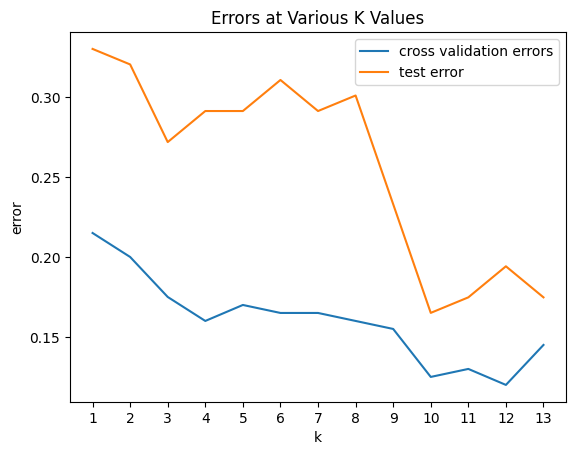

In [108]:
# plot test error and cross validation error

fig1, ax = plt.subplots()

ax.plot(range(1,14), cross_errors, label='cross validation errors')
ax.plot(range(1,14), test_errors, label='test error')
ax.legend()
ax.set_xticks(range(1,14))
ax.set_xlabel('k')
ax.set_ylabel('error')
ax.set_title('Errors at Various K Values')
plt.show()

## Question 6 part b

In [109]:
# get index of features
x1 = 0
x2 = 0
for i in range(len(column_names)):
    if column_names[i] == feature_order[0]:
        x1 = i
    if column_names[i] == feature_order[1]:
        x2 = i

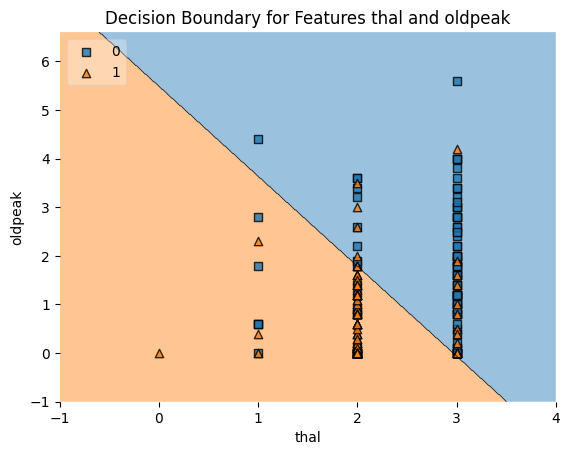

In [110]:
plot_decision_regions(training_data[:, [x1, x2]], training_labels.astype(int), clf=k_models[2], legend=2)
plt.xlabel(str(column_names[x1]))
plt.ylabel(str(column_names[x2]))
plt.title('Decision Boundary for Features ' + str(column_names[x1]) + ' and ' + str(column_names[x2]))
plt.show()